# Historical Stockout Features

This notebook aims to explore the impact of historical stockout features. Questions this notebook aims to answer include: 
1. How does ecnomic features impact sales for items in different departments?
2. How are items individuall affected by economic indicators? 
3. What is the best way to signal the model the nature of the individual item based on this features?

An important piece of information is that 2011 is not a complete date. This is what was driving the odd rolling averages. I need to fix this everywhere. 
Like wise I have learned that the last month (2016-03) is incomplete. I will filter it now. 

My conclussion here is that after applying differencing, these features lose their predictive value as the majority of it revovled around capturing the downard trend of the sales.

In [1]:
# Import required libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months,
        stckt.is_stockout_tgt,
        stckt.is_stockout,
        stckt.stck_indicator_max_days_since_last_sale,
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        --AND stckt.is_stockout_tgt = 0
"""

stockout_feas_query = """
    SELECT 
    *
    FROM `porygon-pipelines.walmart_featurestore.historical_stockout_features`
    WHERE 
        ctx_store_id = 'CA_1'
"""


# Extract data
item_sales = bq_client.load_from_query(sales_query)
stockout_feas = bq_client.load_from_query(stockout_feas_query)

item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2015-11-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    stockout_feas,
    on=["ctx_date_month", "ctx_item_id", "ctx_dept_id"]
)


/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


AttributeError: 'BigQueryClient' object has no attribute 'load_from_query'

# Utils plot functions

In [ ]:
item_sales_focus = df_merged.copy()

def plot_tgt_vs_feature(feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

def plot_tgt_vs_feature_per_dept(feature_name, dept_id):
    fig, ax1 = plt.subplots(figsize=(12,5))
    item_sales_focus = df_merged[df_merged["ctx_dept_id"]==dept_id]
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

# Explore Rolling Averages

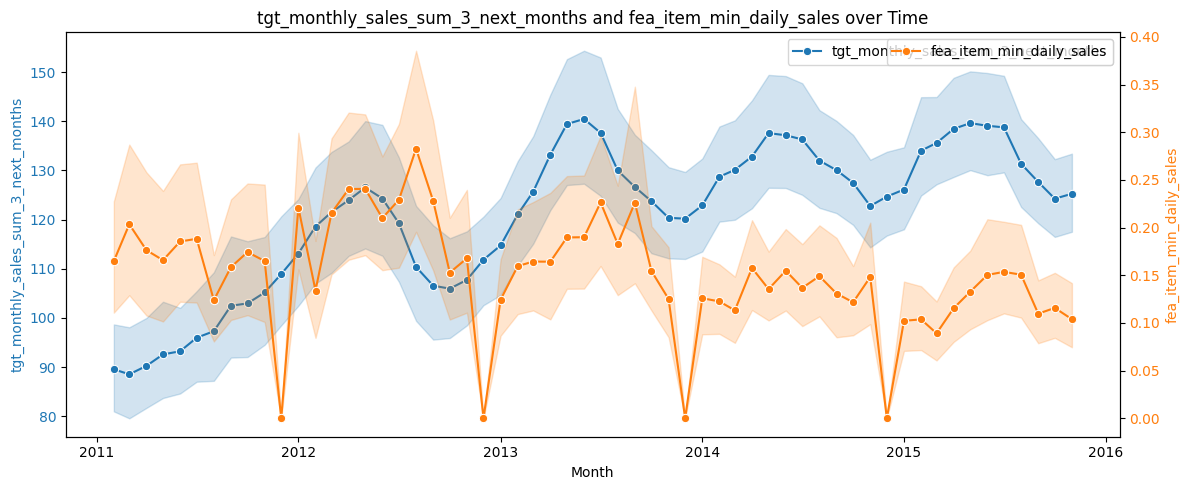

In [187]:
# I think this visualization has to do with the stockouts as 20 days may be too conservative.
# I investigated this trend identified and it is because walmart closes on Dec 25th and no sales are reported for that day. This leads to the min number of daily sales for 
# all times being zero. 
plot_tgt_vs_feature("fea_item_min_daily_sales")

# To analyze this, i think its best to look at the item thresholds

This part is very tricky because items all havae different natures. I have the metrics for a threshold for the 97th percentile per item, but its too noisy. I will ook at this per department instead. 

In [188]:
# Let's begin by extracting the stockout thresholds per item
stockout_thresholds_query = """
    SELECT 
    *
    FROM `porygon-pipelines.walmart_targets_and_filters.stockout_thresholds`
"""

stockout_thresholds = bq_client.load_from_query(stockout_thresholds_query)

df_merged_thresholds = df_merged.merge(
    stockout_thresholds,
    on="ctx_item_id"
)

df_merged_thresholds = df_merged_thresholds[
    ~df_merged_thresholds["stck_indicator_max_days_since_last_sale"].isna()
]


/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 3049 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 3049 rows from custom query.


# KS test with current threshold of 20 per department

The objective of this is to see (per department) if the threshold of 20 is successfully divinding the population. This is if the distribution of monthly sales for months beyond the thresold is statistically diffeerent from the distribution of the months with sales within the threshold. 



In [189]:
# lets begin by creating the thresholds to compare: 
df_merged_thresholds["current_theshold"] = 20

In [ ]:
df_median_per_dept = df_merged_thresholds.groupby(
    "ctx_dept_id"
)[["ctx_item_stockout_threshold"]].quantile(.5).reset_index().rename(columns={"ctx_item_stockout_threshold": "median_97thp_per_dept"})

df_merged_thresholds = df_merged_thresholds.merge(
    df_median_per_dept, 
    on =["ctx_dept_id"],
    how = "left"
)

# Analyze best cutoff based on solid numbers

In [241]:
from scipy.stats import ks_2samp

def calculate_cutoff_results(n):
    dept_id_list = ["FOODS_1", "FOODS_2", "FOODS_3", "HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_1", "HOUSEHOLD_2"]
    ks_list = []
    pvalue_list = []
    stockout_percent_list = []
    percent_zero_stockout_group_list = []
    percent_zero_non_stockout_group_list = []

    colname = f"solid_thrshold_{n}"
    df_merged_thresholds[f"solid_thrshold_{n}"] = n

    for dept_id in dept_id_list:
        dept_data = df_merged_thresholds[(df_merged_thresholds["ctx_dept_id"]==dept_id)]
        stockout_group = dept_data[
            (dept_data["stck_indicator_max_days_since_last_sale"]>=dept_data[colname])
            ]["tgt_monthly_sales"]
        non_stockout_group = dept_data[
            (dept_data["stck_indicator_max_days_since_last_sale"]<dept_data[colname])
            ]["tgt_monthly_sales"]
        percent_zero_stockout_group = (stockout_group==0).sum()/stockout_group.shape[0]
        percent_zero_non_stockout_group = (non_stockout_group==0).sum()/non_stockout_group.shape[0]

        # I changed this so that it countsw the zeros. 
        # Now remove zeroes:
        #stockout_group_nonzero = stockout_group[
        #    (stockout_group["tgt_monthly_sales"]>0)
        #    ]["tgt_monthly_sales"]

        #non_stockout_group_nonzero = non_stockout_group[
        #    (non_stockout_group["tgt_monthly_sales"]>0)
        #    ]["tgt_monthly_sales"]
        #
        percent_excluded = stockout_group.shape[0]/(stockout_group.shape[0]+non_stockout_group.shape[0])

        ks_stat, p_value = ks_2samp(non_stockout_group, stockout_group)
        ks_list.append(ks_stat)
        pvalue_list.append(p_value)
        stockout_percent_list.append(percent_excluded)
        percent_zero_stockout_group_list.append(percent_zero_stockout_group)
        percent_zero_non_stockout_group_list.append(percent_zero_non_stockout_group)

    df_results = pd.DataFrame(dept_id_list, columns = ["ctx_dept_id"])
    df_results["ks_stat"] = ks_list
    df_results["p_value"] = pvalue_list
    df_results["percent_excluded"] = stockout_percent_list
    df_results["percent_zero_stockout_group"] = percent_zero_stockout_group_list
    df_results["percent_zero_non_stockout_group"] = percent_zero_non_stockout_group_list
    df_results["threshold"] = n

    return df_results

In [242]:
# from 1 to 90:
list_of_ns = list(range(1, 91))

df_cutoff_analysis = pd.concat(
    [
        calculate_cutoff_results(n) for n in list_of_ns

    ]
)


In [243]:
df_cutoff_analysis

,ctx_dept_id,ks_stat,p_value,percent_excluded,percent_zero_stockout_group,percent_zero_non_stockout_group,threshold
0,FOODS_1,0.881535,0.000000e+00,0.958385,0.127695,0.000000,1
1,FOODS_2,0.866946,0.000000e+00,0.974996,0.135369,0.000000,1
2,FOODS_3,0.806298,0.000000e+00,0.907576,0.112443,0.000000,1
3,HOBBIES_1,0.776801,3.247665e-99,0.992002,0.074220,0.000000,1
4,HOBBIES_2,0.791743,8.689251e-02,0.999697,0.126290,0.000000,1
...,...,...,...,...,...,...,...
2,FOODS_3,0.752239,0.000000e+00,0.065358,0.785802,0.054237,90
3,HOBBIES_1,0.768484,0.000000e+00,0.048144,0.805112,0.036628,90
4,HOBBIES_2,0.594551,6.335907e-118,0.056297,0.687332,0.092780,90
5,HOUSEHOLD_1,0.711932,0.000000e+00,0.055952,0.745233,0.042902,90


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cutoff_per_dept(dept_id, plot_inflection_point):
    df_cutoff_analysis_dept = df_cutoff_analysis[
        df_cutoff_analysis["ctx_dept_id"]==dept_id
    ].reset_index(drop=True)
    # Line plot: x = threshold, y = ks_stat
    plt.figure(figsize=(10,6))
    
    ax = sns.lineplot(
        data=df_cutoff_analysis_dept,
        x="threshold",
        y="ks_stat",
        marker="o",
    )
    plt.title(f"KS Statistic vs Percent Excluded by Threshold Type - {dept_id}")
    plt.xlabel("Threshold")
    plt.ylabel("KS Statistic")
    plt.axvline(x=plot_inflection_point, color='red', linestyle='--', label='Cutoff Point')

    # Annotate each marker with percent_excluded value, smaller font size
    for i, row in df_cutoff_analysis_dept.iterrows():
        if i % 4 == 0:
            ax.annotate(f"{row['percent_excluded']:.2f}",
                        (row['threshold'], row['ks_stat']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=10,
                        color='black')

    plt.legend()
    plt.tight_layout()
    plt.show()


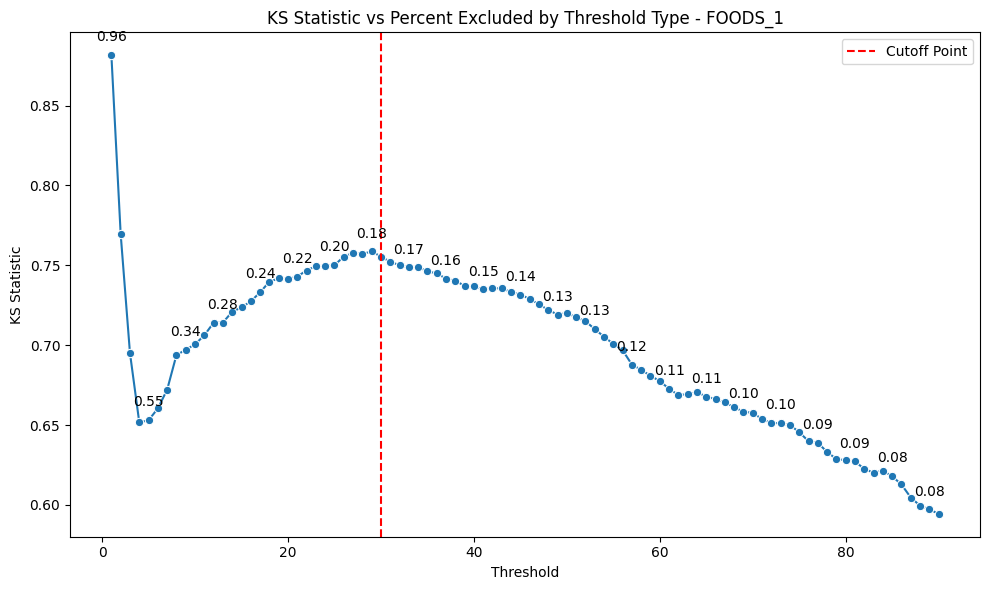

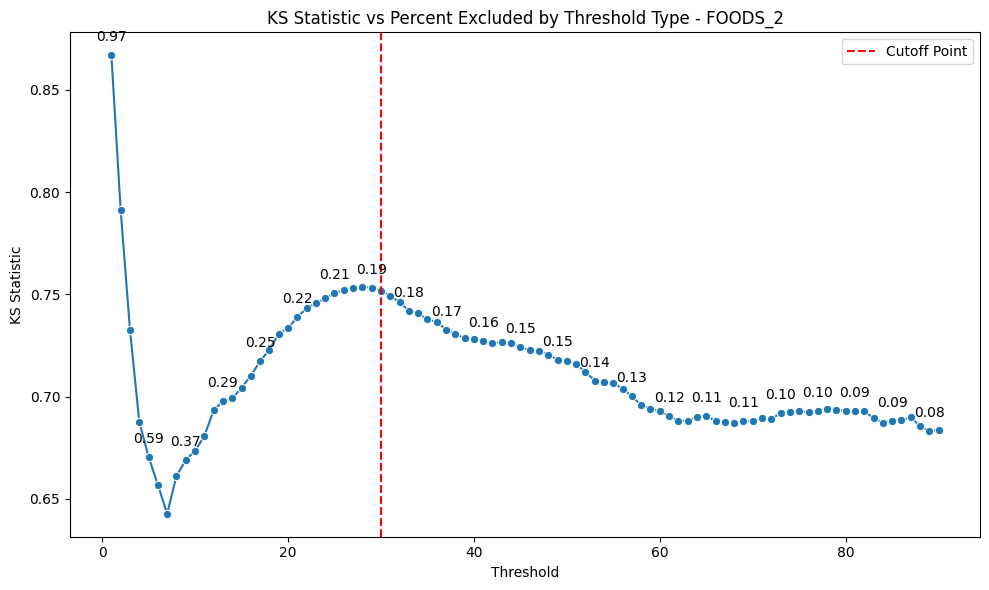

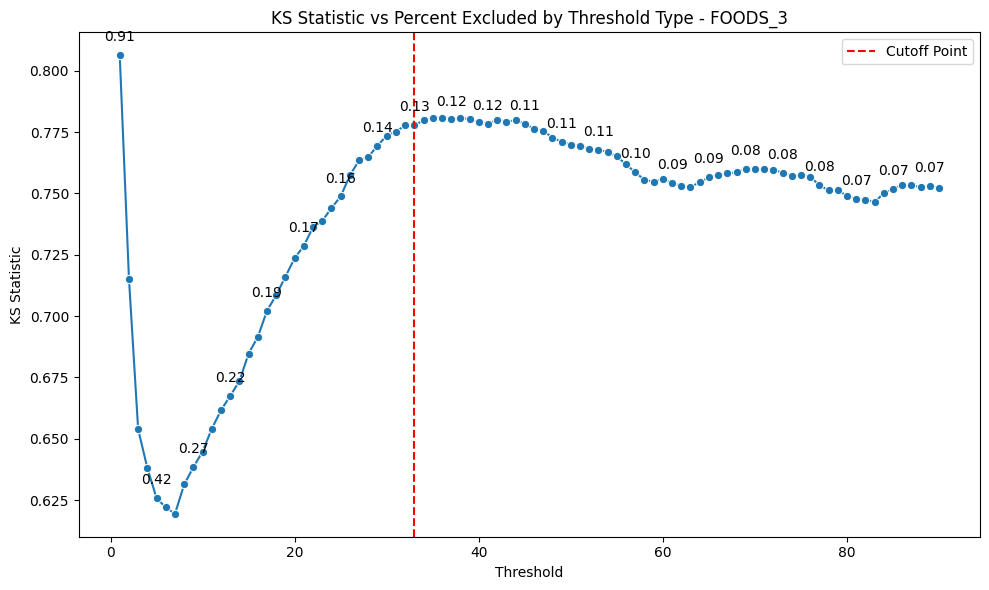

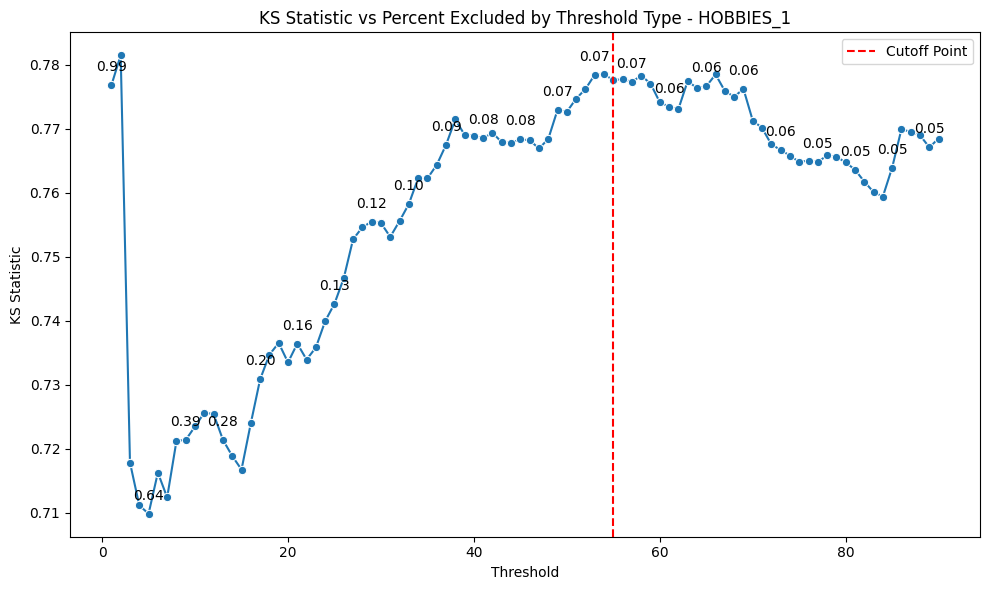

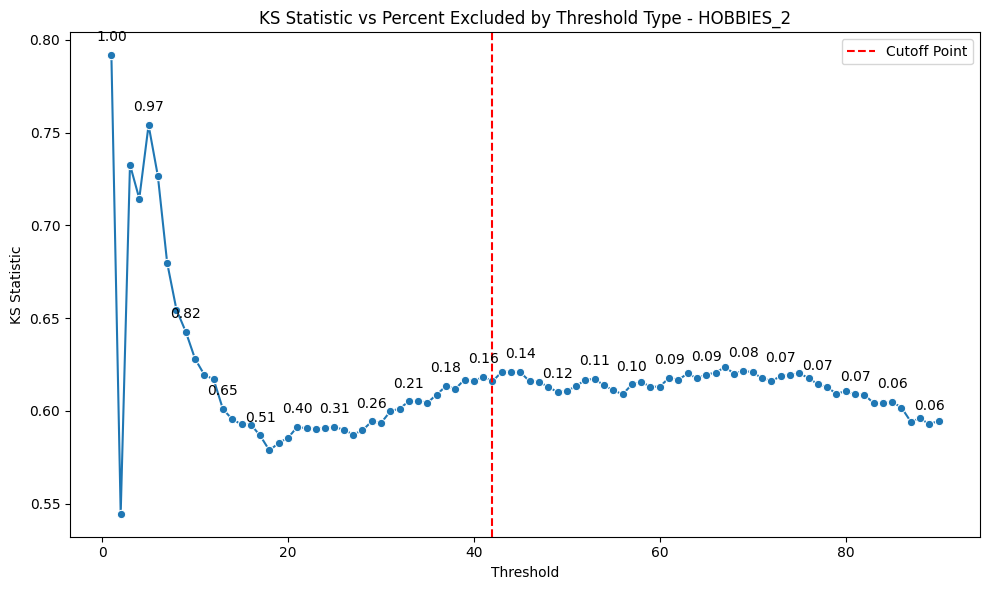

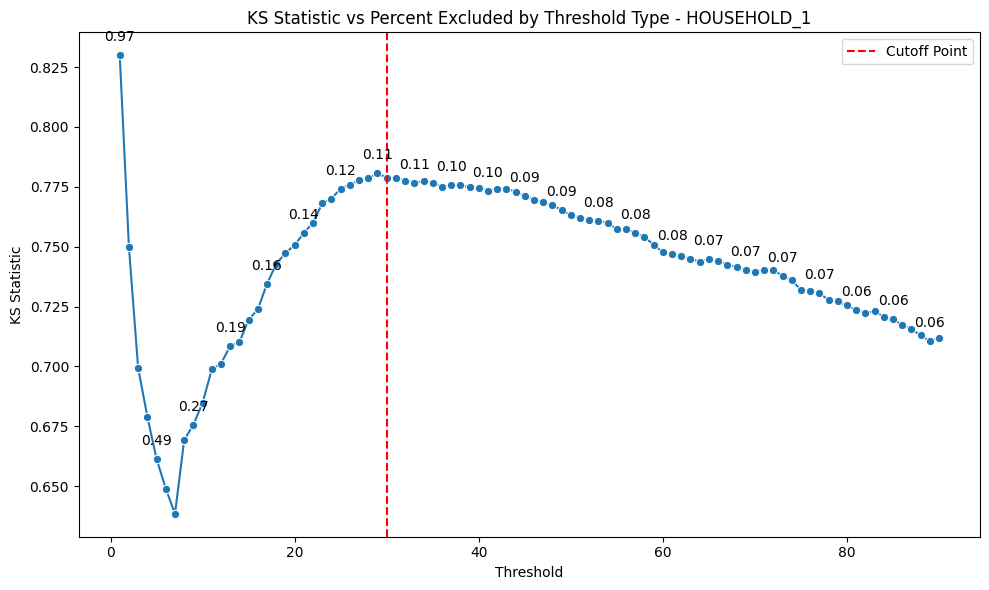

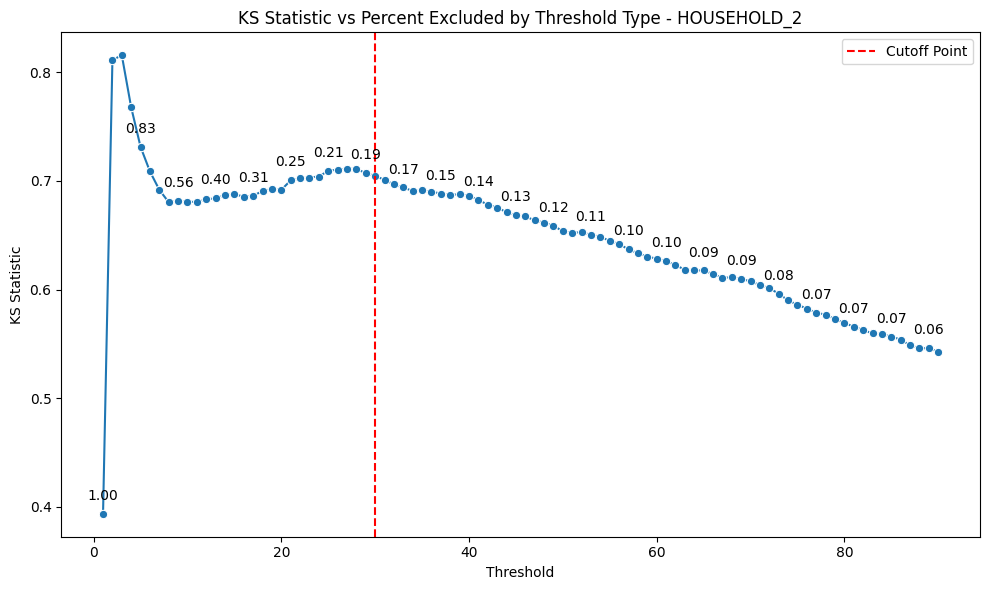

In [260]:
plot_cutoff_per_dept("FOODS_1", 30)
plot_cutoff_per_dept("FOODS_2", 30)
plot_cutoff_per_dept("FOODS_3", 33)
plot_cutoff_per_dept("HOBBIES_1", 55)
plot_cutoff_per_dept("HOBBIES_2", 42)
plot_cutoff_per_dept("HOUSEHOLD_1", 30)
plot_cutoff_per_dept("HOUSEHOLD_2", 30)

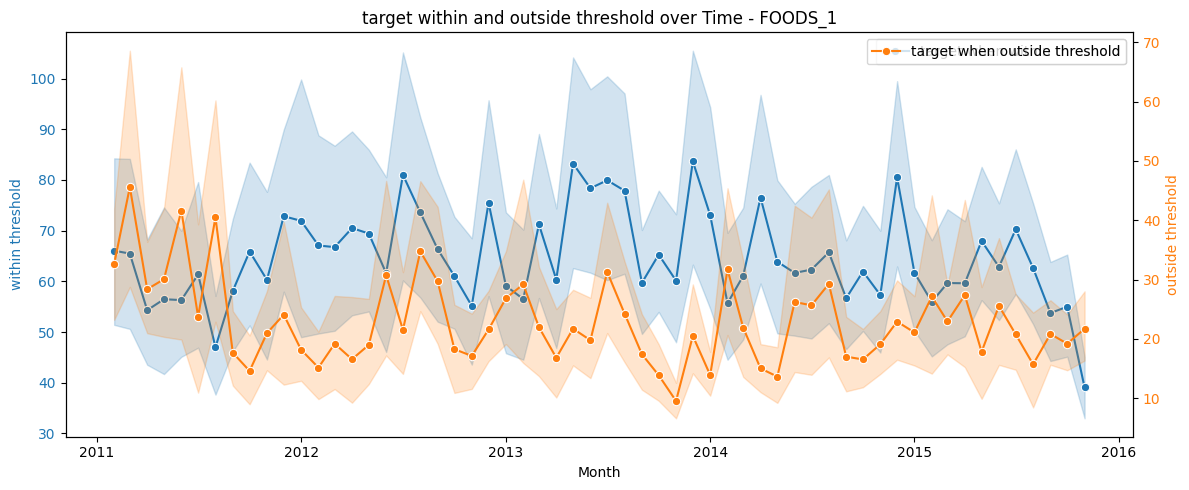

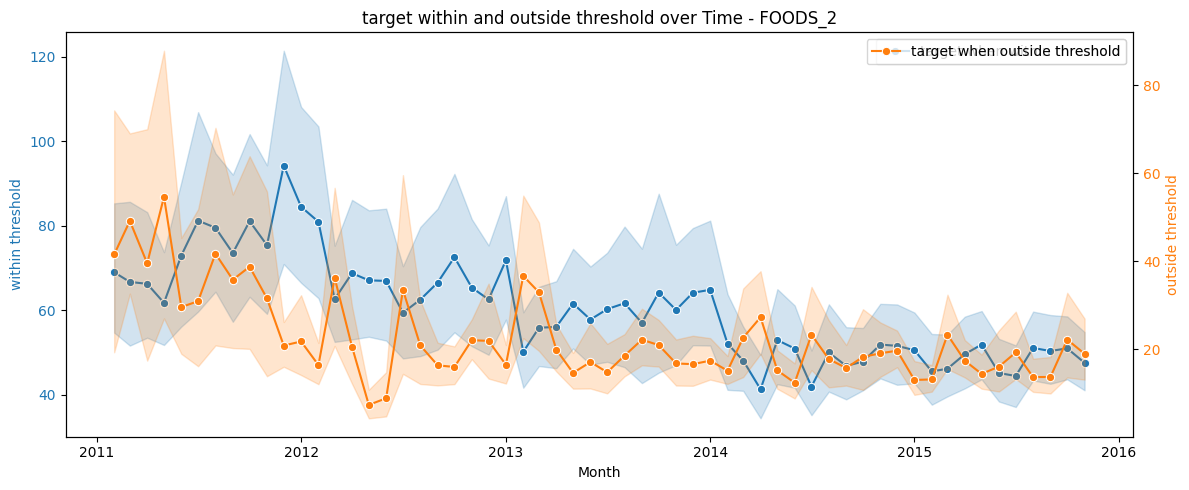

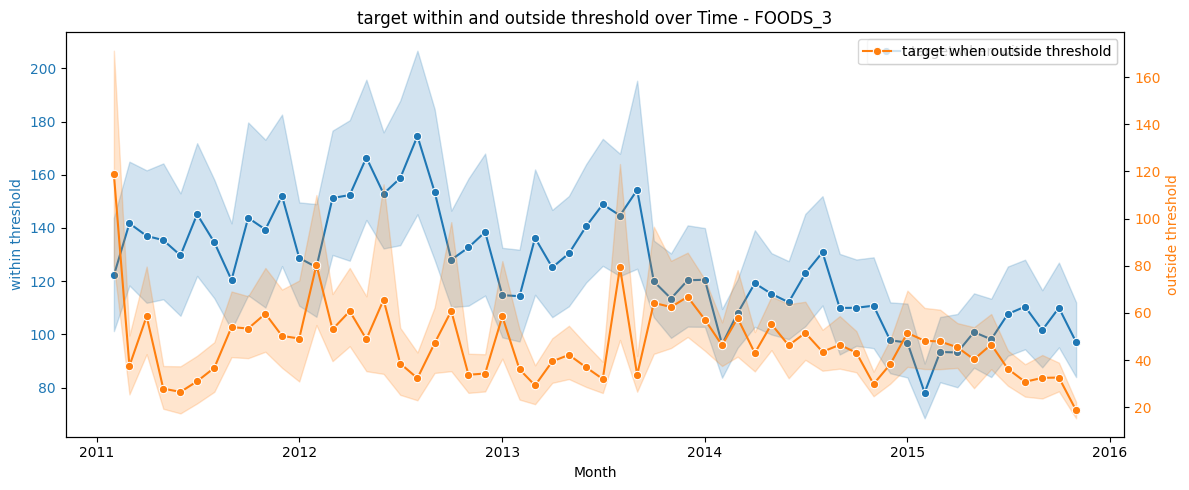

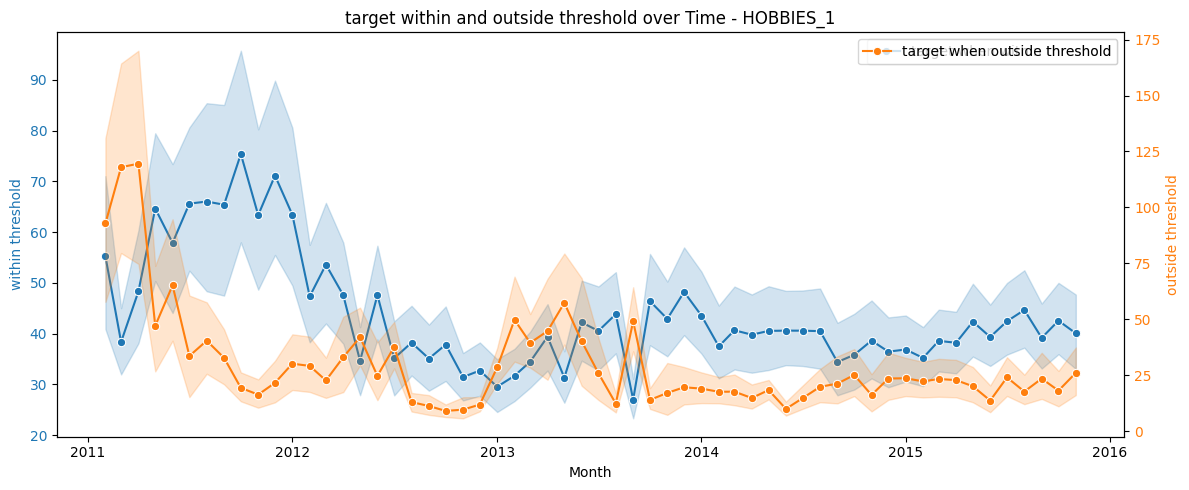

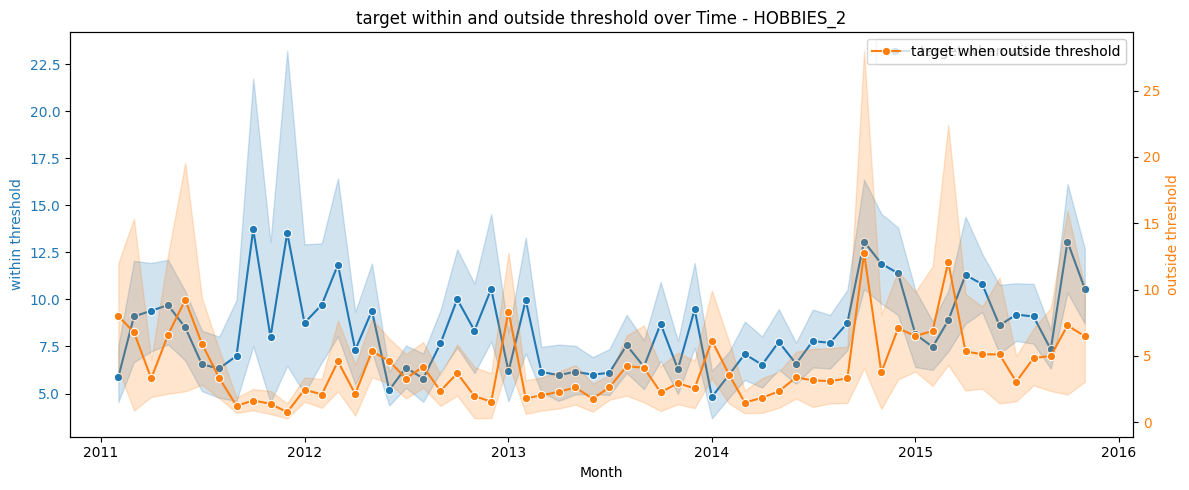

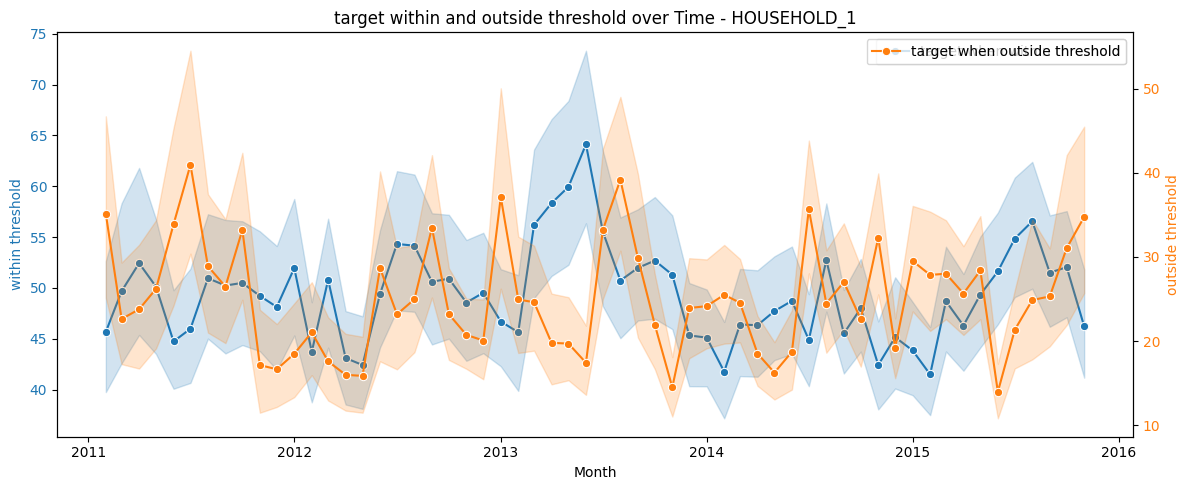

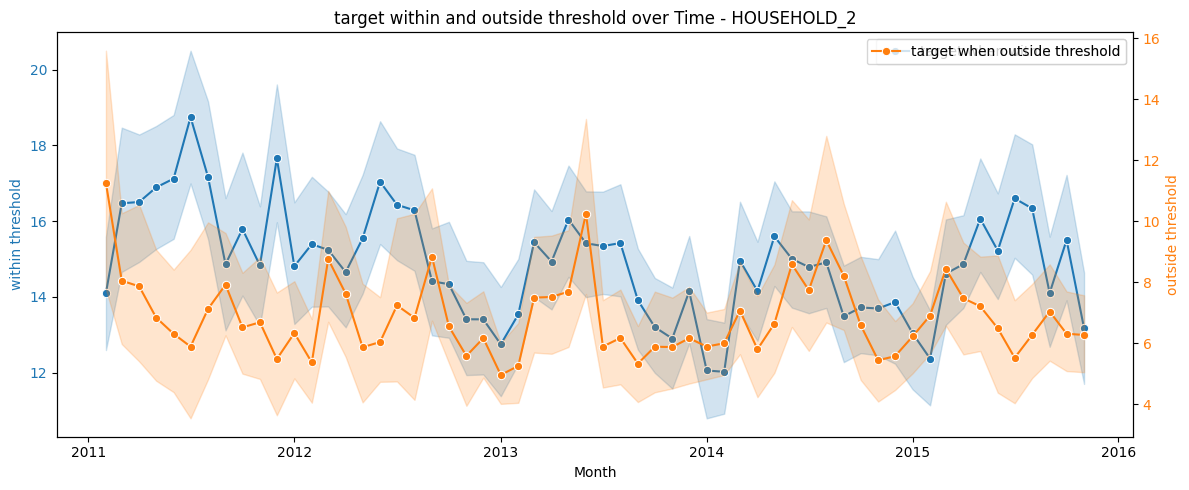

In [ ]:
def plot_stockout_threhodls_per_dept(dept_id):
    df_merged_within_thresholds = df_merged_thresholds[
        (df_merged_thresholds["ctx_item_stockout_threshold"] >= df_merged_thresholds["stck_indicator_max_days_since_last_sale"]) &
        (df_merged_thresholds["ctx_dept_id"] == dept_id)
    ]

    df_merged_outside_thresholds = df_merged_thresholds[
        (df_merged_thresholds["ctx_item_stockout_threshold"] < df_merged_thresholds["stck_indicator_max_days_since_last_sale"]) &
        (df_merged_thresholds["ctx_dept_id"] == dept_id)
    ]

    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged_within_thresholds, x='ctx_date_month', y='tgt_monthly_sales', marker='o', ax=ax1, color='tab:blue', label="target when within threshold")
    ax1.set_ylabel('within threshold', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged_outside_thresholds, x='ctx_date_month', y="tgt_monthly_sales", marker='o', ax=ax2, color='tab:orange', label="target when outside threshold")
    ax2.set_ylabel("outside threshold", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'target within and outside threshold over Time - {dept_id}')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

plot_stockout_threhodls_per_dept("FOODS_1")
plot_stockout_threhodls_per_dept("FOODS_2")
plot_stockout_threhodls_per_dept("FOODS_3")
plot_stockout_threhodls_per_dept("HOBBIES_1")
plot_stockout_threhodls_per_dept("HOBBIES_2")
plot_stockout_threhodls_per_dept("HOUSEHOLD_1")
plot_stockout_threhodls_per_dept("HOUSEHOLD_2")

(2302, 166)


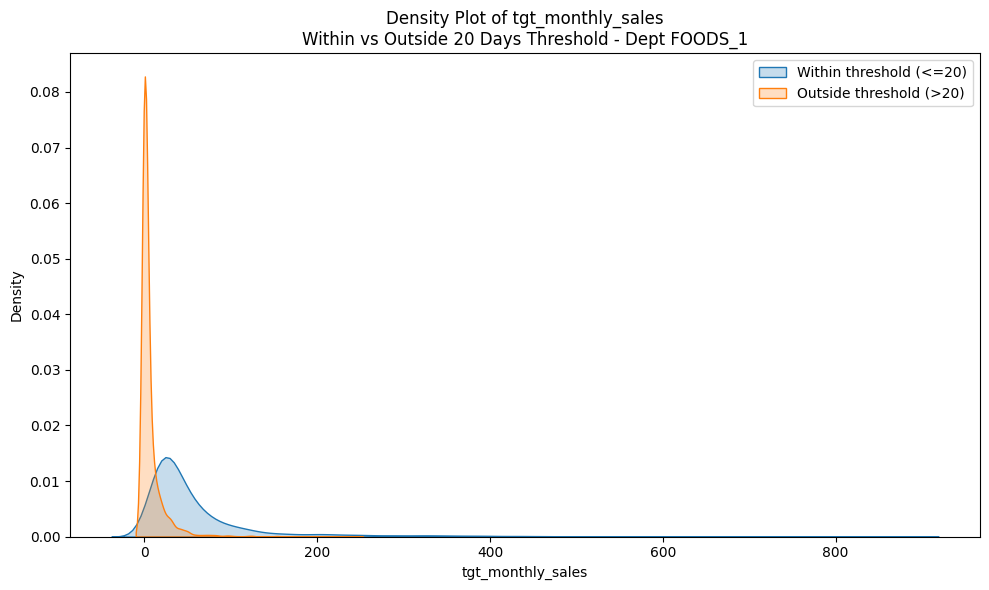

(4080, 166)


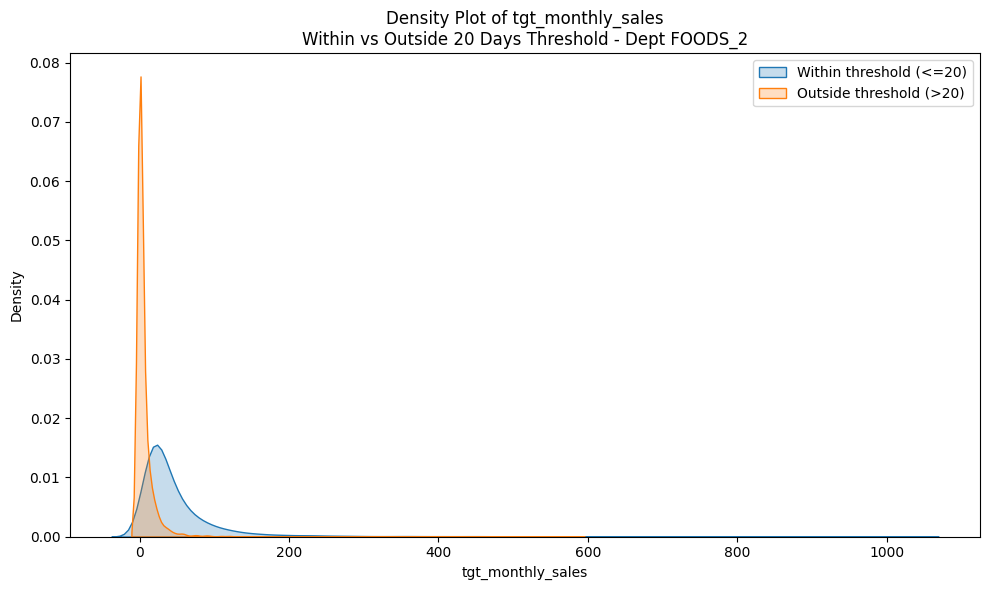

(6456, 166)


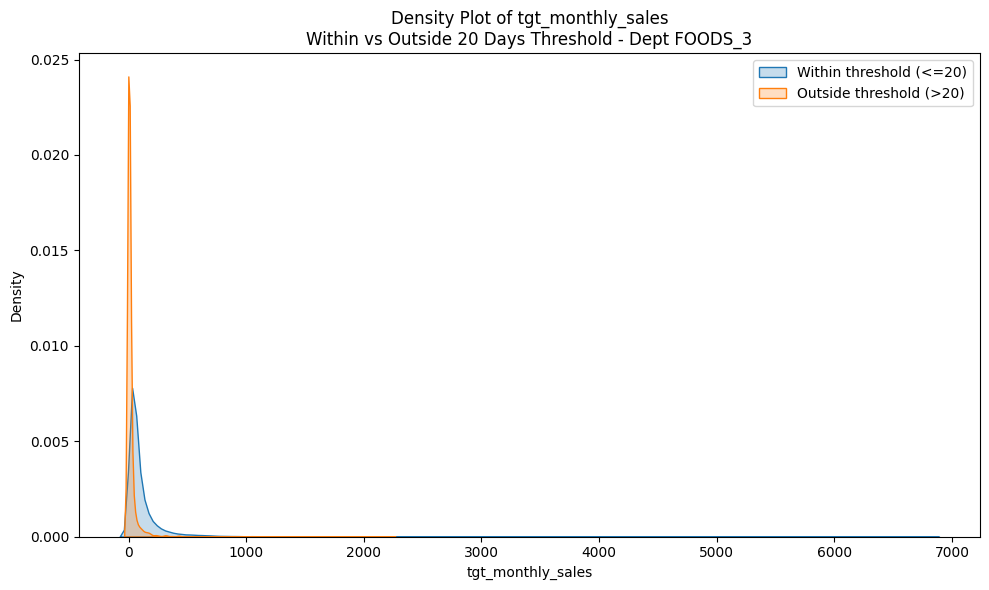

(3144, 166)


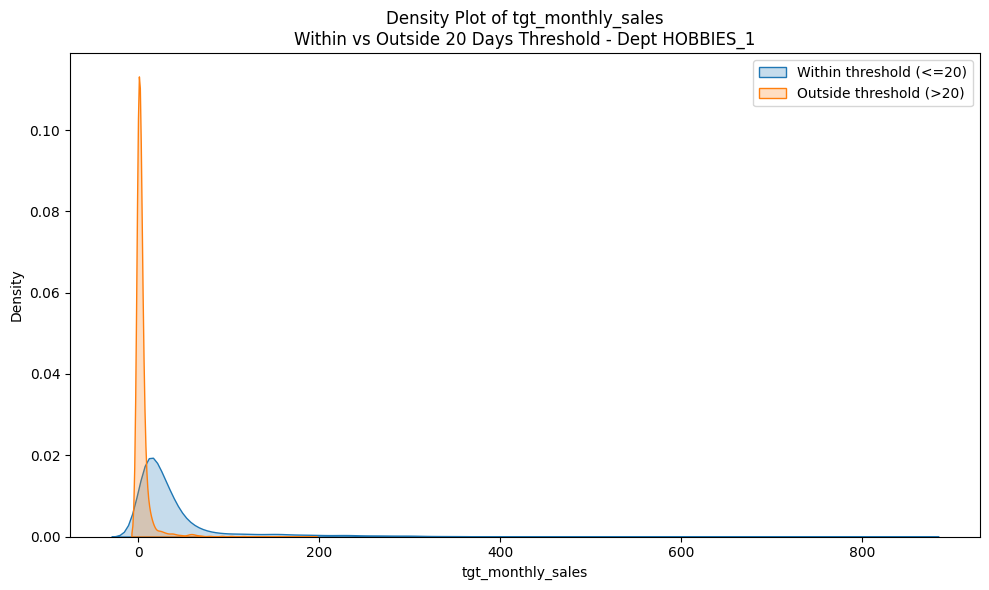

(2606, 166)


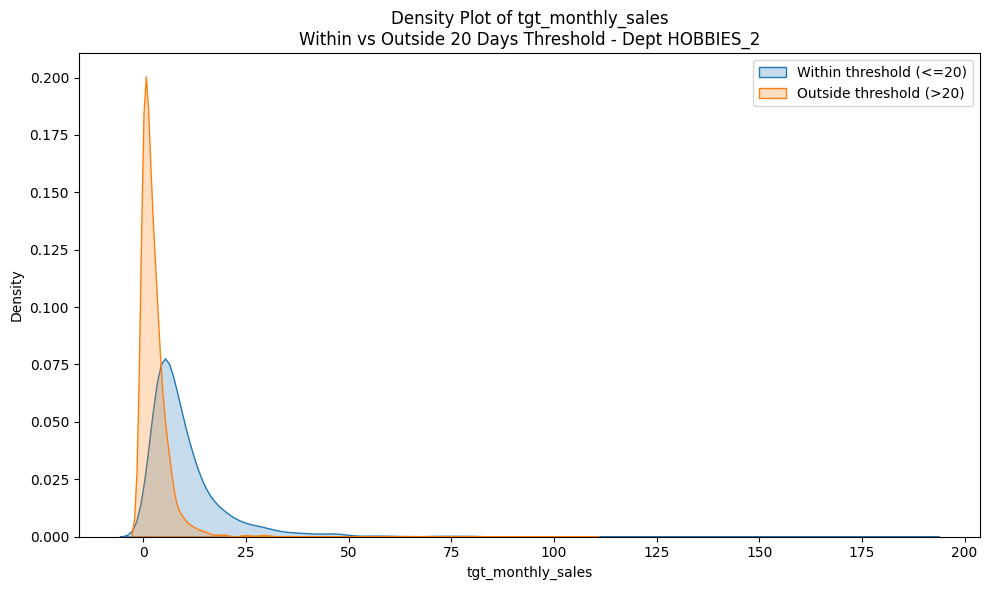

(3215, 166)


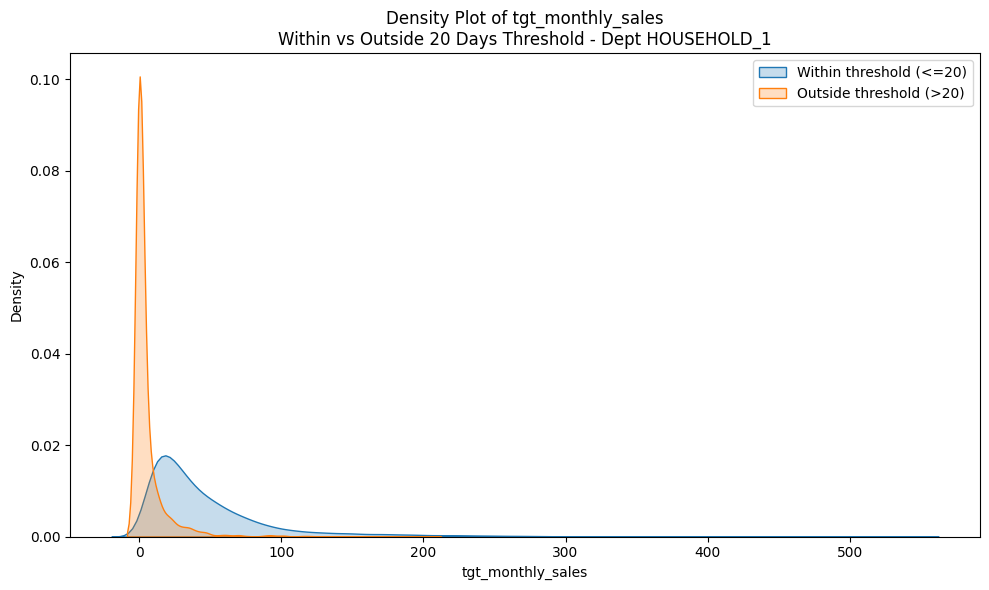

(6237, 166)


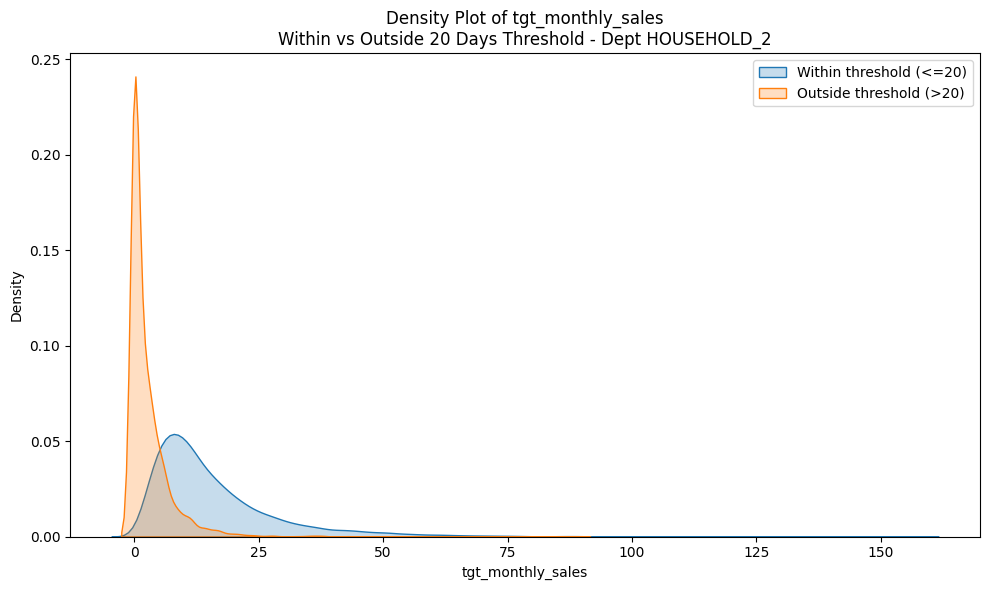

In [ ]:
def plot_stockout_thresholds_density_per_dept_20(dept_id):
    df_merged_within_thresholds = df_merged_thresholds[
        (20 >= df_merged_thresholds["stck_indicator_max_days_since_last_sale"]) &
        (df_merged_thresholds["ctx_dept_id"] == dept_id)
    ]
    df_merged_outside_thresholds = df_merged_thresholds[
        (20 < df_merged_thresholds["stck_indicator_max_days_since_last_sale"]) &
        (df_merged_thresholds["ctx_dept_id"] == dept_id)
    ]
    print(df_merged_outside_thresholds.shape)

    plt.figure(figsize=(10,6))
    sns.kdeplot(df_merged_within_thresholds['tgt_monthly_sales'], fill=True, color='tab:blue', label='Within threshold (<=20)')
    sns.kdeplot(df_merged_outside_thresholds['tgt_monthly_sales'], fill=True, color='tab:orange', label='Outside threshold (>20)')
    plt.title(f'Density Plot of tgt_monthly_sales\nWithin vs Outside 20 Days Threshold - Dept {dept_id}')
    plt.xlabel('tgt_monthly_sales')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for each department
plot_stockout_thresholds_density_per_dept_20("FOODS_1")
plot_stockout_thresholds_density_per_dept_20("FOODS_2")
plot_stockout_thresholds_density_per_dept_20("FOODS_3")
plot_stockout_thresholds_density_per_dept_20("HOBBIES_1")
plot_stockout_thresholds_density_per_dept_20("HOBBIES_2")
plot_stockout_thresholds_density_per_dept_20("HOUSEHOLD_1")
plot_stockout_thresholds_density_per_dept_20("HOUSEHOLD_2")


# Observation
The current threshold does not do a good job with household 2 and hobbies 2. 
